In [1]:
%reset -f
import gc
gc.collect()

from math import *
import numpy as np

import matplotlib.pyplot as plt

import time

import tensorflow as tf

from sklearn.model_selection import train_test_split

2023-09-13 16:59:26.053744: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 16:59:26.077776: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 16:59:26.078307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 16:59:26.598889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# TOD macro parameters\n",
time_len = 10.
hz = 156.
hit_rate = 1.4*1e-3
time_step = 1./hz
print("the time step is: %.2f ms" %(time_step*1e3))

# Arbitrary signal shape parameters
test_rate = 10.
hit_high_mean = 3.5
hit_high_sigma = 0.5
hit_width_mean = 1.
hit_width_sigma = 0.1
wn_fraction = 0.3
hit_len = 11

# Random seeds initialization
tf.random.set_seed(42)
np.random.seed(24)

the time step is: 6.41 ms


In [3]:
# Convertion of time range in seconds into bin number
time_bins = int(time_len*hz)
print("The number of TOD time bins is: ", time_bins)

The number of TOD time bins is:  1560


In [4]:
# Hit shape function scaled to the correct time range
def direct_hit_func(a, c_factor, time_step=1/156, check=False):

    time_bins = 0.07/time_step
    if check:
        time = np.arange(time_bins, step=time_step)
    else:
        time = np.arange(time_bins)
    c= c_factor*2*1e-3/time_step
    b = 3.20*c
    mu1 = 2*c
    mu2 = 2.5*c
    
    main = 2.5*np.exp(-((time-mu1)/c)**2)*np.exp(-np.exp(-time/c))
    tail = np.exp(-(np.log(time-mu2))**2/(2*b**2))/ (time*b*np.sqrt(2*np.pi))
    tail = np.nan_to_num(tail)
    
    return a*(main + tail)


# white noise
def thermal_noise_func(a, time_range):
    
    return a*np.random.rand(time_range)

/tmp/ipykernel_3924056/1842260697.py:15: RuntimeWarning: invalid value encountered in log
  tail = np.exp(-(np.log(time-mu2))**2/(2*b**2))/ (time*b*np.sqrt(2*np.pi))


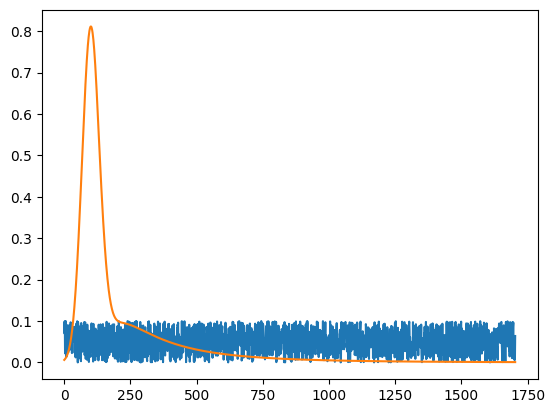

In [5]:
hit = direct_hit_func(1, 1, check=True)
wn = thermal_noise_func(1, len(hit))
fig = plt.plot(np.arange(len(wn)), 0.1*wn)
fig = plt.plot(np.arange(len(hit)), 0.37*hit)

Hit time bins for 156 Hz =  11


/tmp/ipykernel_3924056/1842260697.py:15: RuntimeWarning: invalid value encountered in log
  tail = np.exp(-(np.log(time-mu2))**2/(2*b**2))/ (time*b*np.sqrt(2*np.pi))


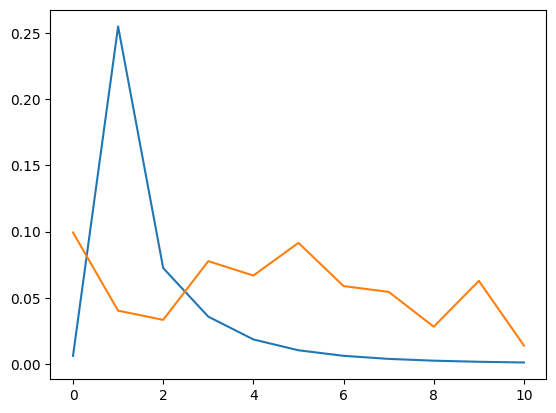

In [6]:
hit = direct_hit_func(1, 1)
wn = thermal_noise_func(1, len(hit))
#plt.plot(np.arange(len(hit)), hit)
#plt.plot(np.arange(len(tail)), tail)
print("Hit time bins for 156 Hz = ", len(hit))

fig = plt.plot(np.arange(len(hit)), 0.37*hit)
fig = plt.plot(np.arange(len(wn)), 0.1*wn)

In [7]:
## Generate the array of hits along the time series using random gaussian extracted coefficients
def hit_inject(time_bins, rate_mean, time_len, a_mean, a_sigma, c_mean, c_sigma, w):
    
    rate = np.random.normal(rate_mean)
    
    wn = thermal_noise_func(w, time_bins)
    
    N_hits = int(np.abs(np.random.normal(rate*time_len, rate*time_len/10.)))
    a_arr = np.random.normal(a_mean, a_sigma, N_hits)
    c_arr = np.random.normal(c_mean, c_sigma, N_hits)
    
    # Right boundary escluso
    tin = ((time_bins-0.07/time_step)*np.random.rand(N_hits)).astype(int)
    inj_hits = np.zeros(time_bins)
    for i in range(len(tin)):
        hit = direct_hit_func(a_arr[i], c_arr[i])
        inj_hits[tin[i]:tin[i]+len(hit)] += hit
        
    return {"hits": inj_hits, "white_noise": wn, "cr_tod": inj_hits+wn}

/tmp/ipykernel_3924056/1842260697.py:15: RuntimeWarning: invalid value encountered in log
  tail = np.exp(-(np.log(time-mu2))**2/(2*b**2))/ (time*b*np.sqrt(2*np.pi))


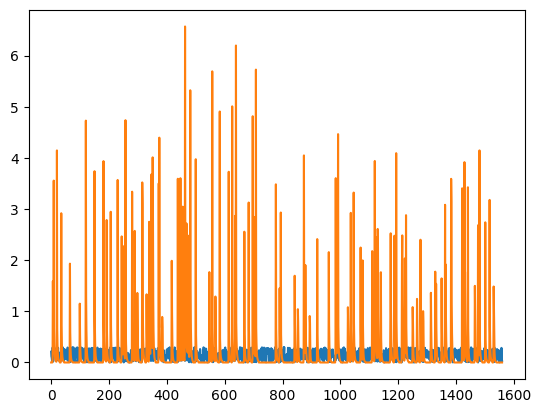

In [8]:
tod_example = hit_inject(time_bins, test_rate, time_len, hit_high_mean, hit_high_sigma, hit_width_mean, hit_width_sigma, wn_fraction)
fig1 = plt.plot(np.arange(time_bins), tod_example["white_noise"])
fig1 = plt.plot(np.arange(time_bins), tod_example["hits"])
plt.show()

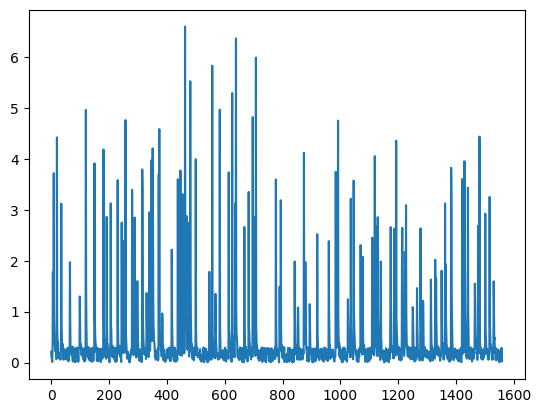

In [9]:
fig2 = plt.plot(np.arange(time_bins), tod_example["cr_tod"])
plt.show()

/tmp/ipykernel_3924056/1842260697.py:15: RuntimeWarning: invalid value encountered in log
  tail = np.exp(-(np.log(time-mu2))**2/(2*b**2))/ (time*b*np.sqrt(2*np.pi))


Homemade TODs have the shape:  (1000, 1560, 1)


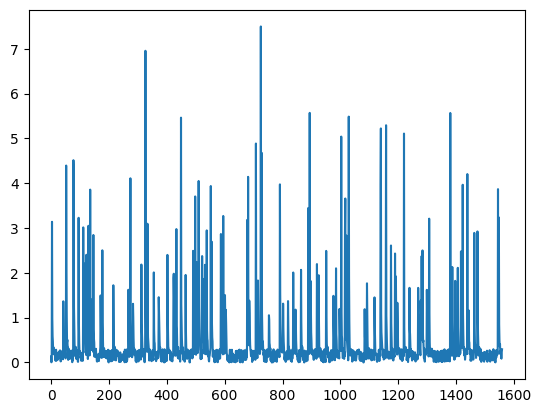

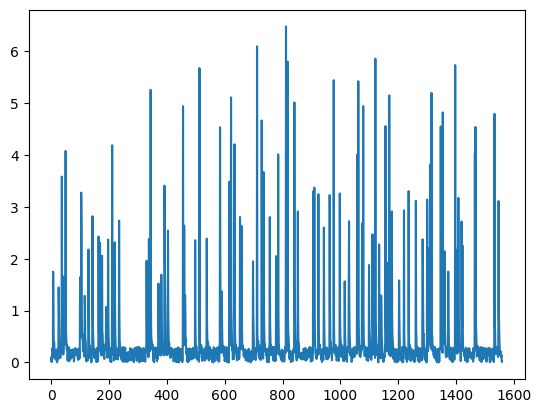

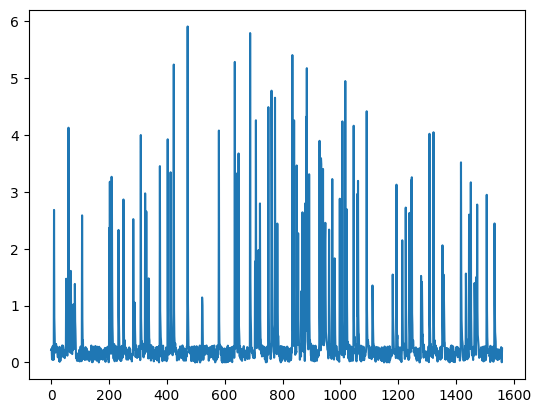

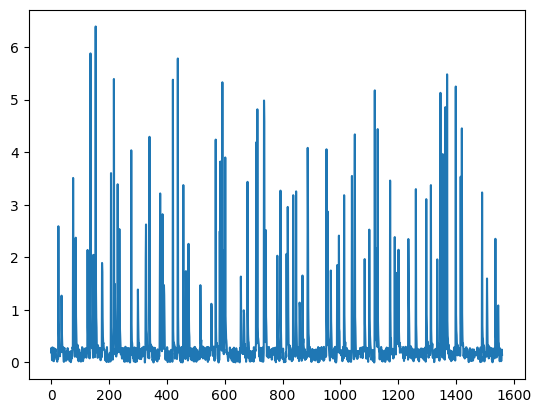

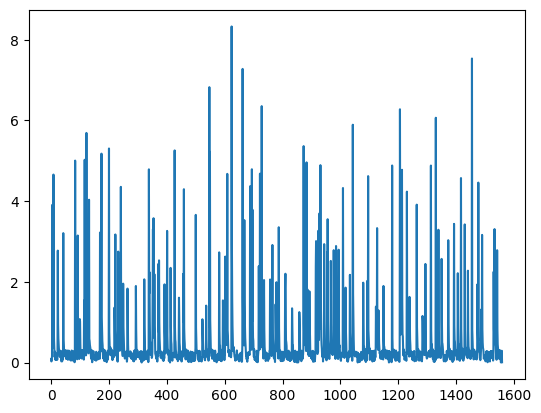

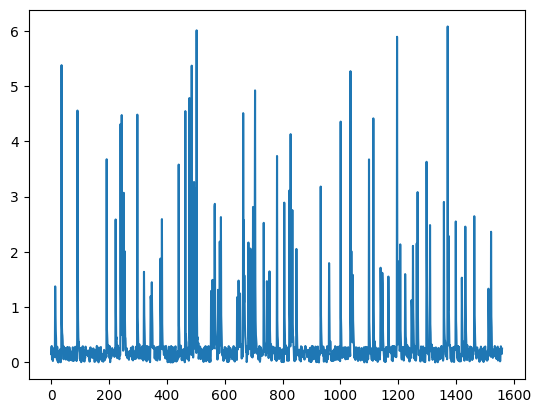

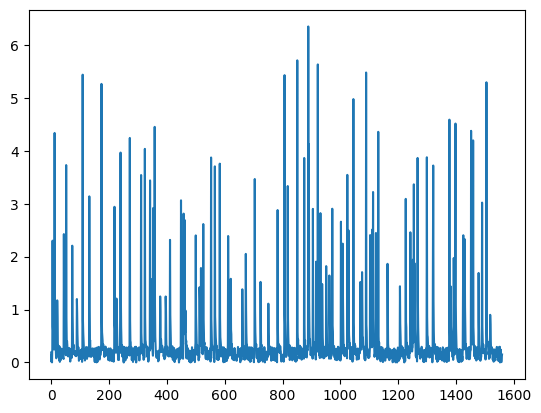

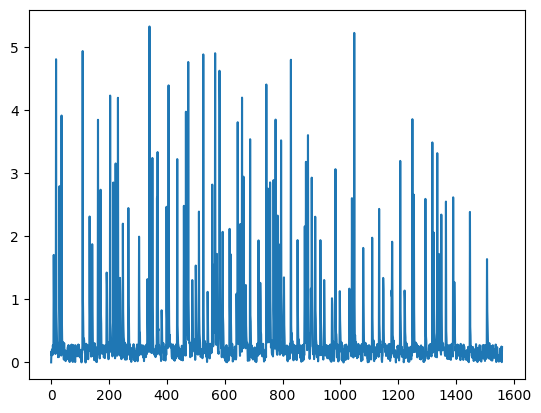

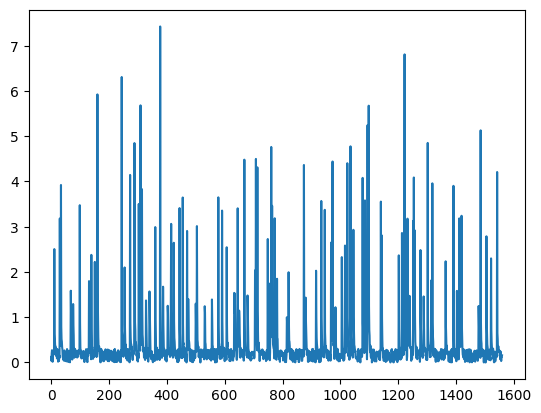

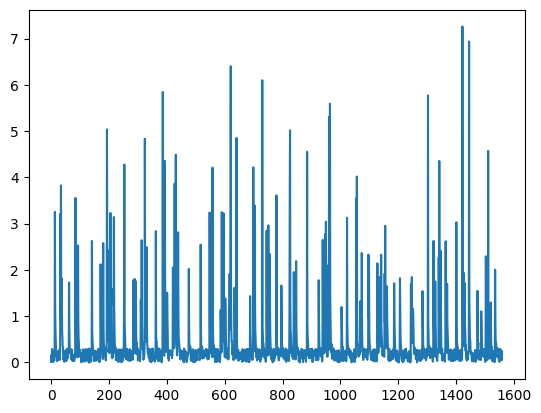

In [10]:
# Generate the sample of TOD images with injected hits
sample_size = 1000
val_split = 0.1

TODs = np.zeros((sample_size, time_bins, 1))
print('Homemade TODs have the shape: ', TODs.shape)

for i in range(sample_size):
    TODs[i,:,0] = hit_inject(time_bins, test_rate, time_len, hit_high_mean, hit_high_sigma, hit_width_mean, hit_width_sigma, wn_fraction)["cr_tod"]

for j in range(10):
    plt.plot(np.arange(time_bins), TODs[j*100,:,0])
    plt.show()

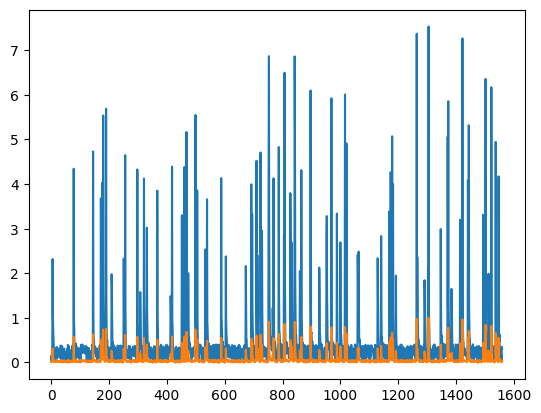

In [11]:
# Normalization of the TODs and split in training and validation samples

def normalize(sample):

    mins = np.repeat(np.min(sample, axis=1), sample.shape[1], axis=1)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=1), sample.shape[1], axis=1)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):

    min_ = np.mean(mins)
    max_ = np.mean(maxs)
    sample = min_ + (max_-min_)*(sample)
  
    return sample

norm_TODs, mins, maxs = normalize(TODs)
TODs_train, TODs_val = train_test_split(norm_TODs, test_size=val_split)

# Plot test of normalization and denormalization
plt.plot(np.arange(time_bins), denormalize(TODs_train[0,:,0], mins, maxs))
plt.plot(np.arange(time_bins), TODs_train[0,:,0])
plt.show()

In [12]:
# Save the generated homemade TODs
dir_name = '../data'

with open(dir_name + 'homemade_TOD.npy', 'wb') as file:
    np.save(file, mins)
    np.save(file, maxs)
    #np.save(file, norm_TODs)
    np.save(file, TODs_train)
    np.save(file, TODs_val)